In [1]:
import re
import phik
import pandas as pd
import seaborn as sns
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
plt.rcParams["figure.figsize"] = (12,8)

In [3]:
# Define paths to datasets and target/feature information
train = 'train.csv'
test = 'test.csv'
index = 'PassengerId'

In [9]:
dtypes = ({
    'Survived': bool, 
    'Pclass':   int, 
    'Name':     'category',
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})
data = pd.read_csv(train, index_col=index, dtype=dtypes)

In [10]:
data.head()

Survived  Pclass  \
PassengerId                     
1               False       3   
2                True       1   
3                True       3   
4                True       1   
5               False       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

### Engineering Deck from Cabin number.
 - The first letter of the Cabin number represents the deck so we will extract.

In [11]:
data['Deck'] = data['Cabin'].apply(lambda x: x[0])

### Engineering Title from Name
 - We can gain from information from the Name feature but extracting the Title.
 - We find that 4 titles dominate, and group all others together.

In [12]:
data['Title'] = data['Name'].apply(lambda x: re.split(',|\.', x)[1].strip())

# Check frequency of each title.
print(data['Title'].value_counts())

# Boolean mask of any title NOT in list
otherTitles = ~data['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master'])

# Replace non-standard titles with other to reduce cardinality.
data['Title'].loc[otherTitles] = 'Other'

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
the Countess      1
Sir               1
Capt              1
Jonkheer          1
Ms                1
Don               1
Mme               1
Lady              1
Name: Title, dtype: int64


/home/stephen/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [13]:
# Check cardinality of each feature
data.apply(pd.Series.nunique).sort_values(ascending=False)

Name        891
Ticket      681
Fare        248
Cabin       147
Age          88
Deck          8
Parch         7
SibSp         7
Title         5
Embarked      3
Pclass        3
Sex           2
Survived      2
dtype: int64

In [15]:
data

Survived  Pclass  \
PassengerId                     
1               False       3   
2                True       1   
3                True       3   
4                True       1   
5               False       3   
...               ...     ...   
887             False       2   
888              True       1   
889             False       3   
890              True       1   
891             False       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   
...                                                        ...     ...   ...   
887                                      Montvila, Rev. Juozas    male  27.0   
888                               Graham, Miss. Margaret Edith  female  19.0   
889                   Johnston, Miss. Catherine Helen "Carrie"  female   NaN   
890                                      Behr, Mr. Karl Howell    male  26.0   
891                                        Dooley, Mr. Patrick    male  32.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked Deck  \
PassengerId                                                                
1                1      0         A/5 21171   7.2500   NaN        S  NaN   
2                1      0          PC 17599  71.2833   C85        C    C   
3                0      0  STON/O2. 3101282   7.9250   NaN        S  NaN   
4                1      0            113803  53.1000  C123        S    C   
5                0      0            373450   8.0500   NaN        S  NaN   
...            ...    ...               ...      ...   ...      ...  ...   
887              0      0            211536  13.0000   NaN        S  NaN   
888              0      0            112053  30.0000   B42        S    B   
889              1      2        W./C. 6607  23.4500   NaN        S  NaN   
890              0      0            111369  30.0000  C148        C    C   
891              0      0            370376   7.7500   NaN        Q  NaN   

             Title  
PassengerId         
1               Mr  
2              Mrs  
3             Miss  
4              Mrs  
5               Mr  
...            ...  
887          Other  
888           Miss  
889           Miss  
890             Mr  
891             Mr  

[891 rows x 13 columns]

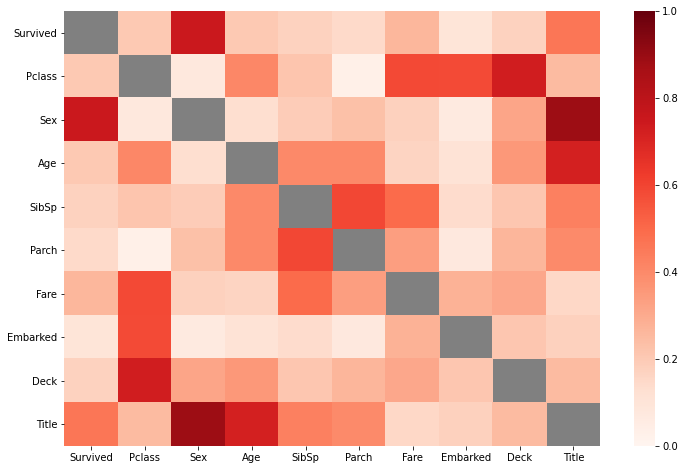

In [14]:
fig, ax = plt.subplots()
intervalCols = ['Age', 'Fare']
dropCols = ['Name', 'Ticket', 'Cabin']
phik = data.drop(dropCols, axis=1).phik_matrix(interval_cols=intervalCols)
g = sns.heatmap(phik, cmap='Reds', vmin=0, vmax=1, mask=(phik==1), ax=ax)
g.set_facecolor('grey')

## Building a simple Decision Tree model
  - Training a decision tree using Sex, Age and Pclass

In [16]:
# Display estimators as diagrams in Jupyter notebook
set_config(display='diagram')

target = 'Survived'
features = ['Sex', 'Pclass', 'Age']

In [17]:
# Read data and isolate target
X = pd.read_csv(train, index_col=index)
y = X.pop(target)

# Split data from training and testing
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=0, train_size=0.8, test_size=0.2)

In [18]:
X_train.head()

Pclass                                    Name     Sex   Age  \
PassengerId                                                                 
141               3           Boulos, Mrs. Joseph (Sultana)  female   NaN   
440               2  Kvillner, Mr. Johan Henrik Johannesson    male  31.0   
818               2                      Mallet, Mr. Albert    male  31.0   
379               3                     Betros, Mr. Tannous    male  20.0   
492               3                     Windelov, Mr. Einar    male  21.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
141              0      2              2678  15.2458   NaN        C  
440              0      0        C.A. 18723  10.5000   NaN        S  
818              1      1   S.C./PARIS 2079  37.0042   NaN        C  
379              0      0              2648   4.0125   NaN        C  
492              0      0  SOTON/OQ 3101317   7.2500   NaN        S

### Define preprocessor
 - Create a transformer for the features(s) as required.
 - Here we just perform ordinal encoding on the 'Sex' feature.
   - Categories are explicity provide so we know that female = 0, male = 1.
 - And we impute Pclass and Age with the median values of those features.
 - Any features not defined in the ColumnTransformer are dropped by default.

In [19]:
transformers = [
    ('Sex',    OrdinalEncoder(categories=[['female', 'male']]), ['Sex']),
    ('other',  SimpleImputer(strategy='median'),                ['Pclass', 'Age'])]

preProcessor = ColumnTransformer(transformers=transformers, remainder='drop')

### Check out processed data
  - View processed data as a sanity check, is everything as expected?

In [20]:
processedData = pd.DataFrame(
    preProcessor.fit_transform(X_train, y_train), 
    columns=features)
processedData.head()

Sex  Pclass   Age
0  0.0     3.0  29.0
1  1.0     2.0  31.0
2  1.0     2.0  31.0
3  1.0     3.0  20.0
4  1.0     3.0  21.0

### Build pipeline and train model

In [21]:
# Combine processor and modelling steps into a Pipeline object
model = Pipeline(steps=[
    ('preProcess', preProcessor),
    ('estimator',  DecisionTreeClassifier(max_depth=3)),
])

In [22]:
# Train model
model.fit(X_train, y_train)

Pipeline(steps=[('preProcess',
                 ColumnTransformer(transformers=[('Sex',
                                                  OrdinalEncoder(categories=[['female',
                                                                              'male']]),
                                                  ['Sex']),
                                                 ('other',
                                                  SimpleImputer(strategy='median'),
                                                  ['Pclass', 'Age'])])),
                ('estimator', DecisionTreeClassifier(max_depth=3))])

In [23]:
# Check score against unseen data
model.score(X_valid, y_valid)

0.7988826815642458

### Visualise decision tree
  - Model predicts...
    - All females suvive **except** children under 2.5 in class 1 or 2 OR adults over 38.5 in class 3.
    - All males die **except** children under 14 in class 1 or 2

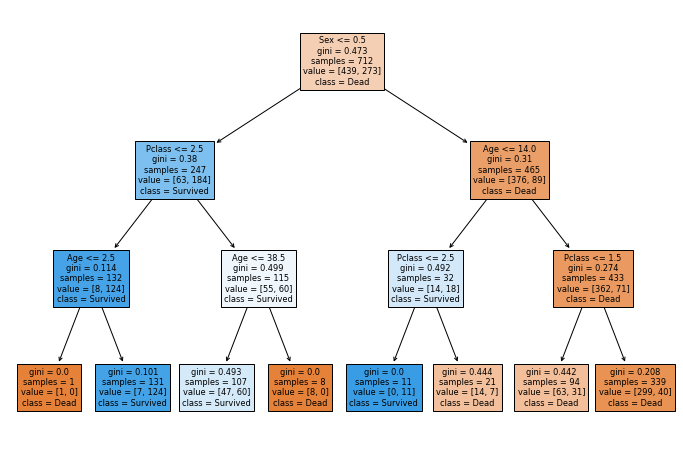

In [24]:
tree = model.named_steps['estimator'] # Extract estimator from Pipeline object
fig, ax = plt.subplots()
_ = plot_tree(tree, feature_names=features, class_names=['Dead', 'Survived'], filled=True, ax=ax)

In [26]:
X_train.loc[(X_train['Sex'] == 'female') & (X_train['Pclass'] <= 2.5) & (X_train['Age'] <= 2.5)]

Pclass                          Name     Sex  Age  SibSp  Parch  \
PassengerId                                                                    
298               1  Allison, Miss. Helen Loraine  female  2.0      1      2   

             Ticket    Fare    Cabin Embarked  
PassengerId                                    
298          113781  151.55  C22 C26        S